# Bayesian Linear Regression Tutorial

## Import code

In [1]:
from bayeslr.bayeslr import *

from scipy.stats import linregress
import matplotlib.pyplot as plt 

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':4,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

## Model definition

Want to predict a single output $y \in \mathbb{R}$ given a vector of features $\mathbf{x} \in \mathbb{R}^d$ 

By defining a basis function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^m$, the model predicts $y$ as a linear combination of potentially non-linear functions of $\mathbf{x}$, weighted by regression coefficients $\mathbf{w} \in \mathbb{R}^m$.  

$$
y = \mathbf{w}^T \phi (\mathbf{x}) + \varepsilon
$$

The model assumes that measurements are corrupted by zero-mean Gaussian noise with precision $\beta$, 


$$
\varepsilon \sim \mathcal{N}(\varepsilon | 0, \beta^{-1})
$$

## Example with $\phi_i(\mathbf{x}) = x_i$

In this example, Scikit-learn's make_regression() is used to generate synthetic data with 100 features, 1 target variable, and 150 samples. Gaussian noise is added to the output variable with a standard deviation of 10, which corresponds to a precision of $\frac{1}{10^{2}}$ = .01.  

In [2]:
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

# number of samples
NS = 100
# number of features
NF = 5
# number of important features 
n_important = 5
# define precision as beta
noise = 30      # std deviation 
beta = (1./noise)**2 # inverse variance 

X, y = sklearn.datasets.make_regression(n_samples=NS, n_features=NF, 
                                        n_informative=n_important, 
                                        n_targets=1, noise=noise)

Decompose data set into training and testing data, setting aside 1/5 of the data for testing. 

In [3]:
N_train = int(.5*NS)

X_train = X[:N_train, :] 
X_test = X[N_train:, :]
Y_train = y[:N_train]
Y_test = y[N_train:]

In [4]:
Xscaler = StandardScaler().fit(X_train)
X_train = Xscaler.transform(X_train)
X_test  = Xscaler.transform(X_test)

Yscaler = StandardScaler().fit(np.vstack(Y_train))
Y_train = Yscaler.transform(np.vstack(Y_train)).ravel()
Y_test  = Yscaler.transform(np.vstack(Y_test)).ravel()

Fit a Bayesian linear regression model and maximize evidence function

In [5]:
blr = LR()
blr.fit(X_train, Y_train)

Evidence -11.888
Evidence 23.483
Evidence 29.976
Evidence 30.169
Evidence 30.172
Pass count  1


# Make predictions on test data

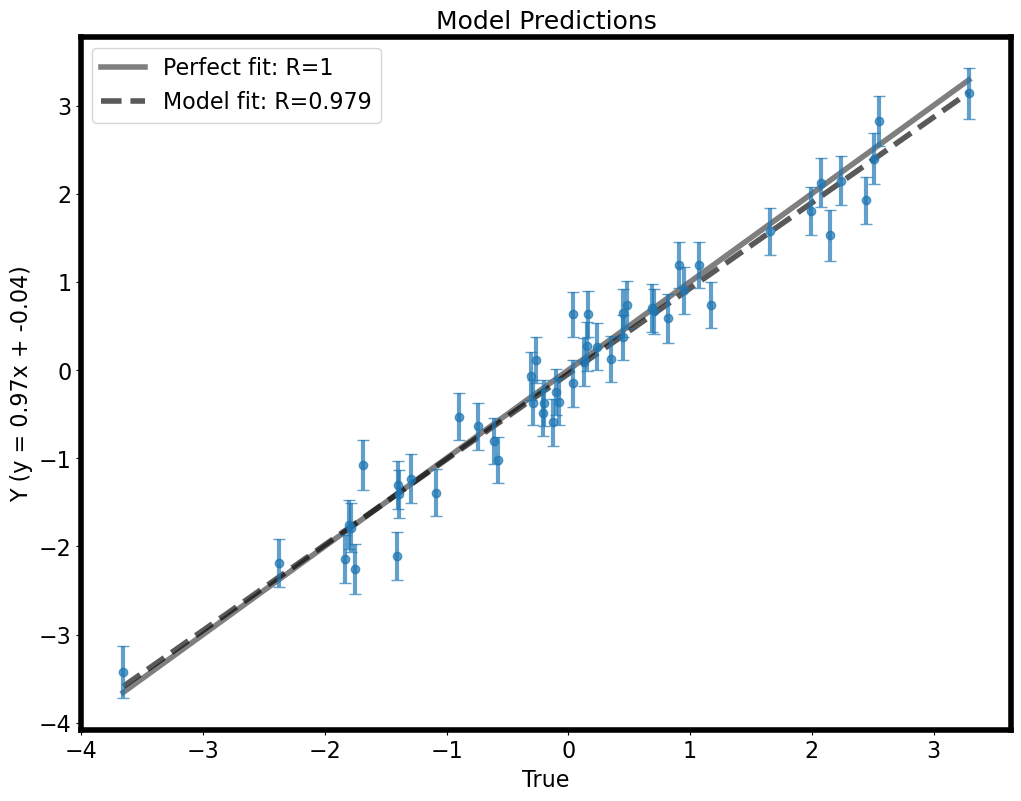

In [6]:
Y, Y_stdv = blr.predict(X_test)

OneToOne = np.linspace(np.min(Y_test), np.max(Y_test), 100)
plt.plot(OneToOne, OneToOne, 'k', alpha=.5, label="Perfect fit: R=1")

lr_stats = linregress(Y_test, Y)
y_fit = OneToOne*lr_stats.slope + lr_stats.intercept

plt.plot(OneToOne, y_fit, 'k--', alpha=.65, label=r"Model fit: R={:.3f}".format(lr_stats.rvalue))
plt.errorbar(Y_test, Y, linewidth=3, capsize=4, linestyle='none', marker='o', alpha=.7, yerr = Y_stdv)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("True", fontsize=16)
plt.ylabel("Y (y = {:.2f}x + {:.2f})".format(lr_stats.slope, lr_stats.intercept), fontsize=16)
plt.title(r"Model Predictions", fontsize=18)
plt.savefig("Figures/example_1.png", dpi=100)
plt.show()

In [7]:
import math 
from scipy.stats import norm

t_dist = lambda x, b: b * np.sqrt(1 / (2*np.pi)) * (b + x**2 / 2) ** (-1.5) * math.gamma(1.5) 
norm_dist = norm(loc=0, scale=np.sqrt(1/blr.beta))

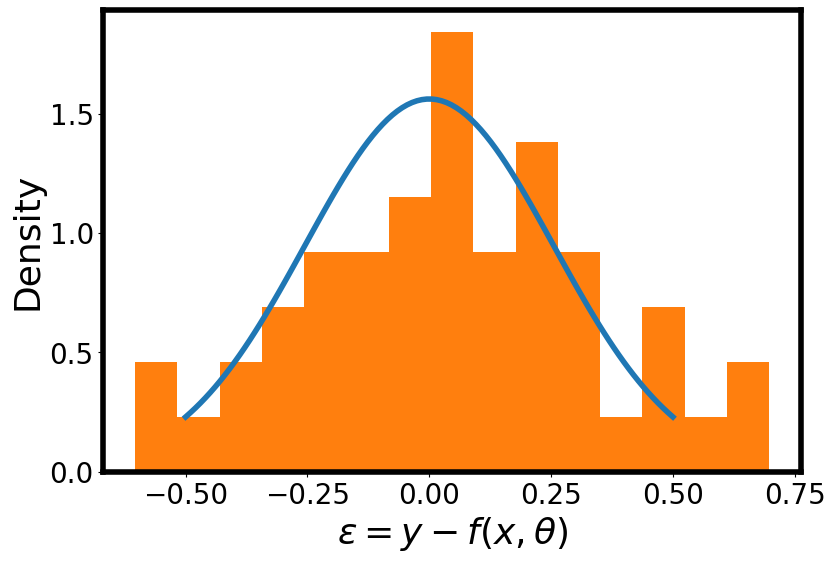

In [8]:
plt.figure(figsize=(9, 6))
x = np.linspace(-.5, .5, 100)
# plt.plot(x, t_dist(x, 1e-3), linewidth=4)
plt.plot(x, norm_dist.pdf(x), linewidth=4)
plt.hist(Y_test - Y, bins=15, density=True)
# plt.xlim([-.5, .5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Density", fontsize=26)
plt.xlabel(r"$\varepsilon = y - f(x, \theta)$", fontsize=26)
# plt.savefig("Noise_model_validation.pdf")
plt.show()

## Example with $\phi_i(\mathbf{x}) = [1, x_i, x_i^2, ..., x_i^5]^T$

Generate data with response that is non-linear in x

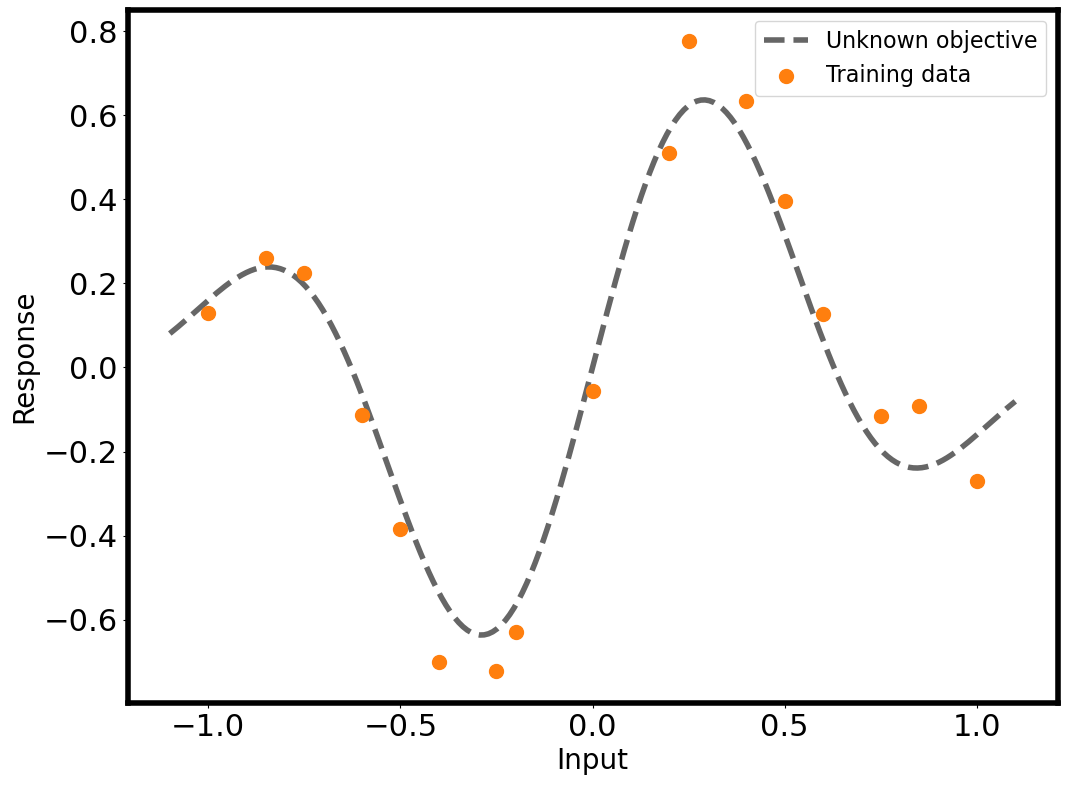

In [9]:
def f(x, noise):
    return .7*np.sin(5 * x) * (1 - np.tanh(x ** 2)) + np.random.randn() * noise/100

def generate_data(Xlist, noise=0.):
    Nsamples = len(Xlist)
    X = np.zeros([Nsamples, 1])
    Y = np.zeros(Nsamples)
    
    for i in range(Nsamples):
        X[i, :] = Xlist[i]
        # add some standard Gaussian noise to Y
        Y[i] = f(Xlist[i], noise)

    return np.vstack(X), np.vstack(Y)

# train data points
Xlist = [-1, -.85, -.75, -.6, -.5, -.4, -.25, -.2, 0, .2, .25, .4, .5, .6, .75, .85, 1]
X_train, Y_train = generate_data(Xlist, noise=10.0)
X_test, Y_test = generate_data(list(np.linspace(-1.1, 1.1, 200)))

inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

Define basis function

In [10]:
def x_basis(X):
    b = np.vstack(np.ones(X.shape[0]))
    return np.concatenate((b, X, X**2, X**3, X**4, X**5, X**6), -1)

Fit a Bayesian linear regression model and maximize evidence function

In [11]:
blr = LR()
blr.fit(x_basis(X_train), Y_train)

Evidence -5.325
Evidence 1.457
Evidence 3.781
Evidence 4.805
Evidence 5.560
Evidence 6.066
Evidence 6.369
Evidence 6.578
Evidence 6.741
Evidence 6.877
Evidence 6.998
Evidence 7.118
Evidence 7.268
Evidence 7.517
Evidence 8.072
Evidence 9.462
Evidence 11.988
Evidence 13.792
Evidence 14.196
Evidence 14.298
Evidence 14.357
Evidence 14.399
Evidence 14.430
Evidence 14.455
Evidence 14.473
Evidence 14.488
Pass count  1


Make predictions on test data

In [12]:
Y, Y_stdv = blr.predict(x_basis(X_test))

Plot results

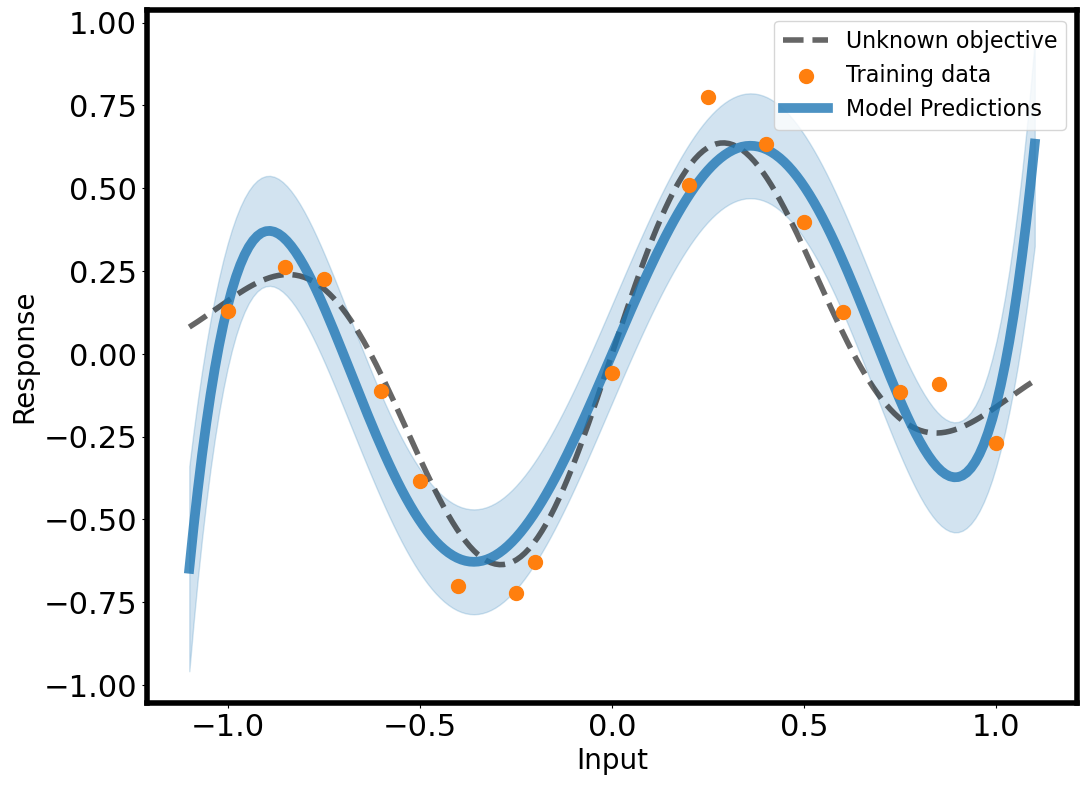

In [13]:
inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = 1. 
plt.fill_between(X_test.ravel(), Y - unc_factor*Y_stdv, Y + unc_factor*Y_stdv, 
                 color='C0', alpha=0.2, zorder=1)

#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
#plt.ylim([-1.9, 1.5])
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig("Figures/example_2.png", dpi=100)
plt.show()